# Data Preparation

Author: Michael Dear, April 2024

This notebook is based on the following DEA notebooks:
* [Parallel Processing With Dask Beginner's Guide](https://knowledge.dea.ga.gov.au/notebooks/Beginners_guide/09_Parallel_processing_with_Dask/)
* [Calculating Band Indices How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Calculating_band_indices/)
* [Generating Composite Images How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Generating_composites/)
* [Extract and Analyse Data for Multiple Polygons](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Analyse_multiple_polygons/)


## Setup

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import geopandas as gpd

from datacube.drivers.netcdf import write_dataset_to_netcdf

import sys
sys.path.insert(1, '../../Tools/')

from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices

# For masking using a polygon
from shapely.geometry import mapping

# Turn off warnings 
import warnings
warnings.filterwarnings('ignore')

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="Create_dataset")

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [1]:
netcdf_dir = '../data/netcdf/'
img_dir = '../data/img/'
vector_dir = '../data/vector/'
geotiff_dir = '../data/geoTIFF/'

spatial_res = 10 # Spatial resolution of the raster dataset in metres
crs = 3577

## Create Dask Client

In [3]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43615,Workers: 1
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:44367,Total threads: 2
Dashboard: /user/mjdear68@gmail.com/proxy/40173/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:43779,


## Step 1: Choose a study area
Use *one* of the methods below to set the bounding box for the study area.

### Method 1: Bounding box from centre point

In [102]:
# Grose Valley, NSW
cpoint = (-33.5976, 150.3651)
buffer = 0.0875
study_area_lat = (cpoint[0]+buffer, cpoint[0]-buffer)
study_area_lon = (cpoint[1]-buffer, cpoint[1]+buffer)

### Method 2: Bounding box from polygon

In [4]:
# Load the polygon
poly = gpd.read_file(vector_dir+'lockleys-pilon.geojson')

In [5]:
poly.head()

,Name,geometry
0,lockleys-pilon-outline,"POLYGON ((150.39334 -33.62688, 150.39343 -33.6..."


In [6]:
# Set the CRS to EPSG:4326
poly = poly.to_crs(4326)

<Axes: >

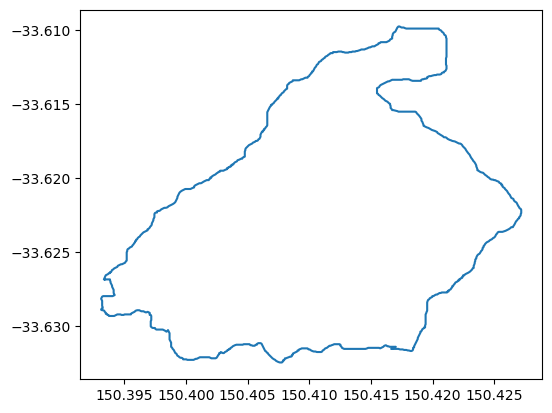

In [7]:
# Plot to check
poly.boundary.plot()

In [8]:
# Get the coordinates of the bounding box
bounds = poly.total_bounds
bounds

array([150.39312885, -33.63245231, 150.42718737, -33.60977046])

In [9]:
# Set the latitude and longitude
study_area_lat = (bounds[1], bounds[3])
study_area_lon = (bounds[0], bounds[2])

In [10]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Select Dates
Use the DEA Maps to select cloud-free or well-masked mostly cloud-free dates. The dates should be as close to the same time of year as possible.

In [13]:
dates = ['2019-11-01', '2019-11-06', '2023-10-21', '2023-10-31']

## Step 3: Extract Data

### Create a Dask chunk size array
This will adjust automatically depending on the bounding box of the study area.

See https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles for converting longitude to metres.

In [85]:
# Approximate pixel dimensions of the study area in the desired spatial resolution.
# Used for setting the dask chunk dimensions.
dask_chunk_size = []
dask_chunk_prop = 0.5 # Use this to set the proportion of the x, y dimensions to set as Dask chunk sizes

# x length
dask_chunk_size.append(
    (np.abs((study_area_lon[1] - study_area_lon[0])*111111
         *np.cos(study_area_lat[0]/(2*np.pi))
         /spatial_res
         *dask_chunk_prop)
         .round()
))

# y length
dask_chunk_size.append(
    (np.abs((study_area_lat[1] - study_area_lat[0])*111111
         /spatial_res
         *dask_chunk_prop)
         .round()
)
)

# Dask will not accept numpy integers. Need to convert to regular integers.
dask_chunk_size = [int(i) for i in dask_chunk_size]
for i in dask_chunk_size:
    print(type(i))

<class 'int'>
<class 'int'>


In [14]:
def get_data(date): 
    '''
    Function to load data for a given date
    '''
    ds = load_ard(dc=dc,
              products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
              measurements = ["nbart_red", "nbart_blue", "nbart_green", "nbart_nir_1"],
              x=study_area_lon,
              y=study_area_lat,
              time=(date),
              output_crs='EPSG:3577', # 3308 NSW Lambert; 3577 Australian Albers; 4326 does not work - not sure why
              resolution=(-spatial_res, spatial_res),
              group_by='solar_day',
              # 'dask_chunks':{"time": 1, "x": dask_chunk_size[0] , "y": dask_chunk_size[1]}, # uncomment if using dask
              cloud_mask='s2cloudless' # Uncomment if using Sentinel data
             )
    return ds

In [15]:
ds_raw = xr.concat([get_data(date) for date in dates], dim='time')

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Loading 1 time steps


In [16]:
ds_raw

<xarray.Dataset>
Dimensions:      (time: 4, y: 297, x: 348)
Coordinates:
  * time         (time) datetime64[ns] 2019-11-01T00:06:14.958968 ... 2023-10...
  * y            (y) float64 -3.789e+06 -3.789e+06 ... -3.792e+06 -3.792e+06
  * x            (x) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.694e+06 1.694e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 254.0 290.0 317.0 ... 442.0 408.0 377.0
    nbart_blue   (time, y, x) float32 247.0 262.0 277.0 ... 214.0 182.0 179.0
    nbart_green  (time, y, x) float32 331.0 382.0 445.0 ... 356.0 318.0 322.0
    nbart_nir_1  (time, y, x) float32 2.351e+03 2.707e+03 ... 2e+03 2.041e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Resample
Resampling along the time dimension can be useful for creating cloud-free composites and for reducing the size of the dataset. It is also possible to resample along the spatial dimensions, although it is probably easier to do this by changing the `resolution` in the `load_ard` function.

In [18]:
ds = ds_raw.resample(time='Y').mean()

### Create additional variables
Using the DEA's `calculate_indices` function is a quick way to add common indices as variables to the dataset.

*Note*: This function will automatically add the new variable to the given dataset.

#### Collections
* For Landsat (i.e. GA Landsat Collection 3), specify collection='ga_ls_3'.
* For Sentinel 2 (i.e. GA Sentinel 2 Collection 3), specify collection='ga_s2_3'

In [19]:
# Add an NDVI variable
ds = calculate_indices(ds, index='NDVI', collection='ga_s2_3')

### Tidy the time dimension

In [20]:
# Drop the empty dates
ds = xr.concat([ds.sel(time='2019'),ds.sel(time='2023')], dim='time')
ds

<xarray.Dataset>
Dimensions:      (y: 297, x: 348, time: 2)
Coordinates:
  * y            (y) float64 -3.789e+06 -3.789e+06 ... -3.792e+06 -3.792e+06
  * x            (x) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.694e+06 1.694e+06
  * time         (time) datetime64[ns] 2019-12-31 2023-12-31
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 213.5 236.5 265.5 ... 437.5 405.5 385.5
    nbart_blue   (time, y, x) float32 189.0 196.0 222.0 ... 222.5 200.0 196.5
    nbart_green  (time, y, x) float32 292.5 330.0 397.5 ... 350.5 331.5 330.5
    nbart_nir_1  (time, y, x) float32 2.37e+03 2.684e+03 ... 2.021e+03 2.04e+03
    NDVI         (time, y, x) float32 0.8347 0.8381 0.8345 ... 0.6658 0.6821
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [21]:
ds = (ds.assign_coords({'year':ds.time.dt.year.astype('int16')})
 .swap_dims({'time':'year'})
 .drop_vars('time')
)
ds

<xarray.Dataset>
Dimensions:      (y: 297, x: 348, year: 2)
Coordinates:
  * y            (y) float64 -3.789e+06 -3.789e+06 ... -3.792e+06 -3.792e+06
  * x            (x) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.694e+06 1.694e+06
    spatial_ref  int32 3577
  * year         (year) int16 2019 2023
Data variables:
    nbart_red    (year, y, x) float32 213.5 236.5 265.5 ... 437.5 405.5 385.5
    nbart_blue   (year, y, x) float32 189.0 196.0 222.0 ... 222.5 200.0 196.5
    nbart_green  (year, y, x) float32 292.5 330.0 397.5 ... 350.5 331.5 330.5
    nbart_nir_1  (year, y, x) float32 2.37e+03 2.684e+03 ... 2.021e+03 2.04e+03
    NDVI         (year, y, x) float32 0.8347 0.8381 0.8345 ... 0.6658 0.6821
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [22]:
# Remove units from year dimension - causes problems when loading saved dataset otherwise.
print(ds.year.attrs)
del ds.year.attrs['units']
print(ds.year.attrs)

{'units': 'seconds since 1970-01-01 00:00:00'}
{}


### Check the dataset size

In [24]:
# Check the dataset size
print('Dataset size = ', np.round(ds.nbytes/1024**3,3), 'Gb')

Dataset size =  0.004 Gb


## Step 4: NDVI Classification

The following NDVI thresholds were used to develop the classification. 
|Class Number|Class Name|Threshold|
|:-:|:-|:-:|
|1|Water|$$\text{NDVI} \lt 0$$|
|2|Bare ground|$$0 \le \text{NDVI} \lt 0.15$$|
|3|Sparse vegetation|$$0.15 \le \text{NDVI} \lt 0.5$$|
|4|Medium-density vegetation|$$0.5 \le \text{NDVI} \lt 0.8$$|
|5|Dense vegetation|$$\text{NDVI} \ge 0.8$$|
|6|No data|nan|

The thresholds were derived from manual review of the study area using [QGIS](www.qgis.org) the following sources:

* [Map Information - Normalised Difference Vegetation Index: Australian Bureau of Meterology](http://www.bom.gov.au/climate/austmaps/about-ndvi-maps.shtml)
* [NDVI, the Foundation for Remote Sensing Phenology : USGS](https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology)

### Create the classification dataset
<a id='create_classification'></a>

In [25]:
# Function to make threshold classification variable
# See https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_calculate_classify_ndvi.html for np.digitize
# See https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html for assigning numpy array to a dataset

# Needed to set the order of the dims explicitly in this case - not the same as ds.dims
def make_class_var(ds, class_bins, var, newvar):
    ds = ds.assign({newvar: (('year','y','x'), (np.digitize(ds[var], class_bins).astype(np.int16)))})
    return ds

In [26]:
NDVI_class_bins = [-np.inf, 0, 0.15, 0.5, 0.8, np.inf]

In [27]:
ds = make_class_var(ds, class_bins = NDVI_class_bins, var='NDVI', newvar='NDVI_Class')
ds

<xarray.Dataset>
Dimensions:      (y: 297, x: 348, year: 2)
Coordinates:
  * y            (y) float64 -3.789e+06 -3.789e+06 ... -3.792e+06 -3.792e+06
  * x            (x) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.694e+06 1.694e+06
    spatial_ref  int32 3577
  * year         (year) int16 2019 2023
Data variables:
    nbart_red    (year, y, x) float32 213.5 236.5 265.5 ... 437.5 405.5 385.5
    nbart_blue   (year, y, x) float32 189.0 196.0 222.0 ... 222.5 200.0 196.5
    nbart_green  (year, y, x) float32 292.5 330.0 397.5 ... 350.5 331.5 330.5
    nbart_nir_1  (year, y, x) float32 2.37e+03 2.684e+03 ... 2.021e+03 2.04e+03
    NDVI         (year, y, x) float32 0.8347 0.8381 0.8345 ... 0.6658 0.6821
    NDVI_Class   (year, y, x) int16 5 5 5 5 5 5 5 5 5 5 ... 4 4 4 4 4 4 4 4 4 4
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [28]:
# Check unique classes present
np.unique(ds.NDVI_Class)

array([2, 3, 4, 5], dtype=int16)

## Step 5: Create a mask

In [35]:
# Copy the first variable in the dataset to use as the basis for the mask
# mask = ds[list(ds.data_vars.keys())[0]].isel(year=0)
mask = xr.DataArray(
            data = np.ones((ds.sizes['y'], ds.sizes['x'])),
            dims = {'y':ds.dims['y'], 'x':ds.dims['x']},
            coords = {'y':ds['y'], 'x':ds['x'],},
            attrs = ds.attrs
)

mask.name = 'mask'

# Make sure the mask and polygon have the same crs
poly = poly.to_crs(crs)
mask = mask.rio.write_crs(crs)

# Clip the mask using the polygon
mask = mask.rio.clip(poly.geometry.apply(mapping), poly.crs, drop=False)

# Set all masked values to nan and all non-masked values to 1
mask = mask.where(mask != -999, np.nan)
mask = mask.where(mask.isnull(), 1)

mask

<xarray.DataArray 'mask' (y: 297, x: 348)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 -3.789e+06 -3.789e+06 ... -3.792e+06 -3.792e+06
  * x            (x) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.694e+06 1.694e+06
    spatial_ref  int64 0
Attributes:
    grid_mapping:  spatial_ref

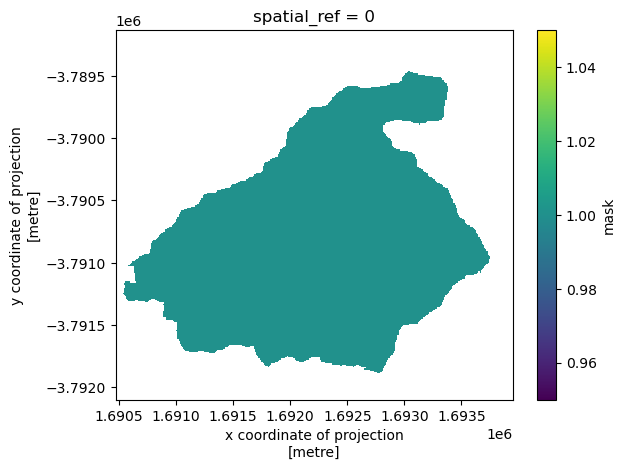

In [36]:
# Test plot
mask.plot()

## Step 6: Check data

After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

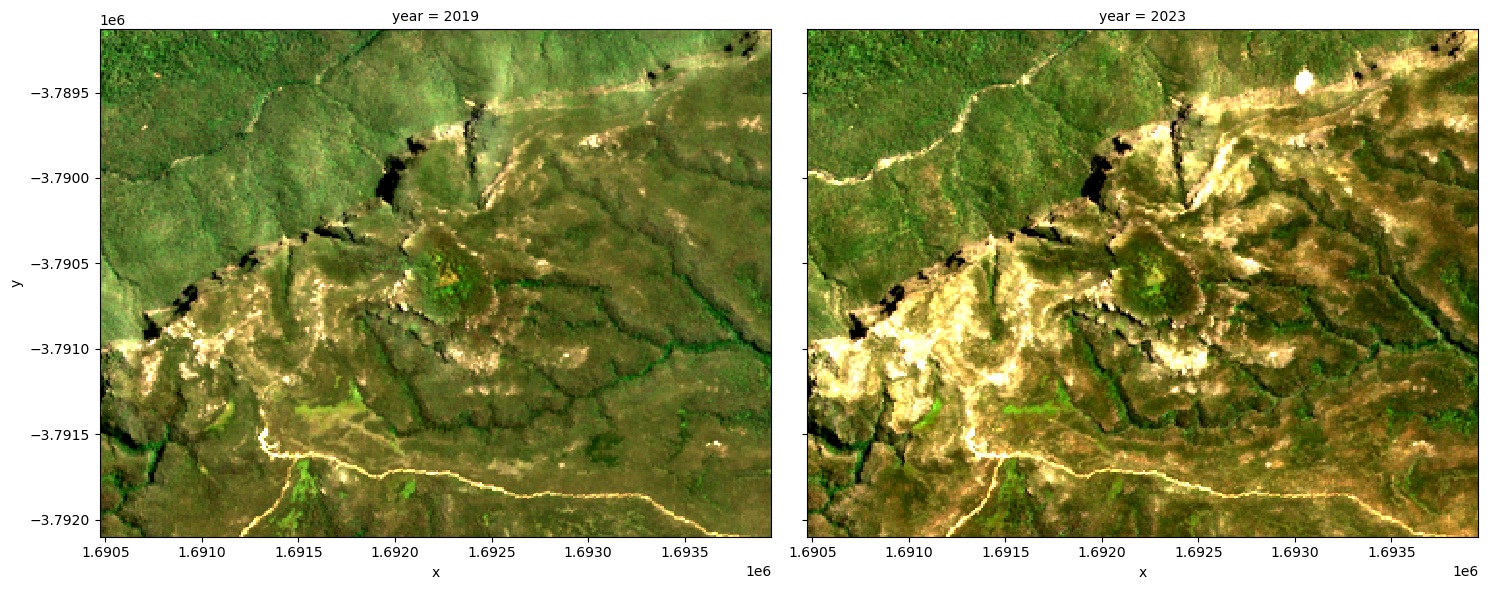

In [142]:
# RGB plot
rgb(ds, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    col='year')

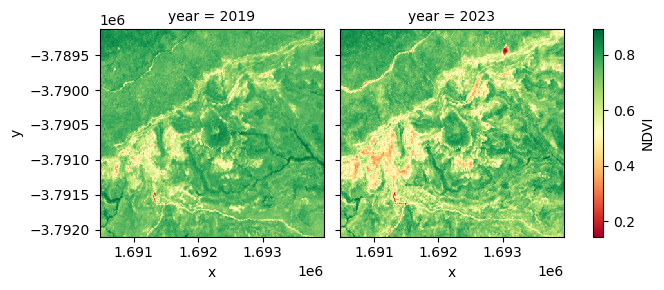

In [30]:
# Facetgrid plot of a single band
ds.NDVI.plot(col='year', cmap='RdYlGn')

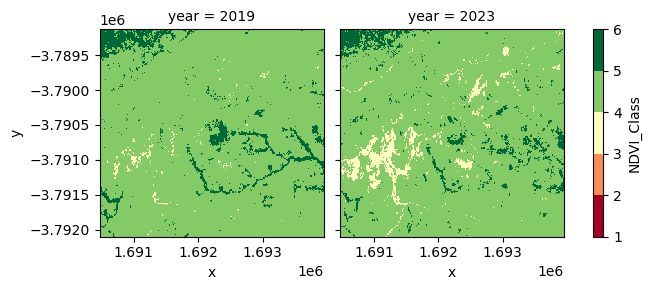

In [34]:
# NDVI_Class
ds.NDVI_Class.plot(col='year', cmap='RdYlGn', levels=np.arange(1,7))

## Step 7: Export data

### netCDF

In [37]:
# Remove CRS info because it prevents file saving
ds.year.attrs=[]

# Save as netCDF
ds.to_netcdf(netcdf_dir+'lockleys-pilon_2019_2023.nc')

In [38]:
# Save mask data array
mask.to_netcdf(netcdf_dir+'mask.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [39]:
# Need to remove 'grid_mapping' from attributes or export to geoTIFF will fail.
print(ds.attrs)
del ds.attrs['grid_mapping']
print(ds.attrs)

{'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'}
{'crs': 'EPSG:3577'}


In [40]:
for yr in ds.year.values:
     (ds
     .sel(year=yr)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+'lockleys-pilon_'+str(yr)+'.tiff')
     )